1. 1-split

In [1]:
import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
y_train = keras.utils.to_categorical(y_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
y_test = keras.utils.to_categorical(y_test)

In [45]:
model = keras.models.load_model('../models/48_1split.h5')
encoder = keras.models.Model(model.inputs, model.get_layer('latent').output)

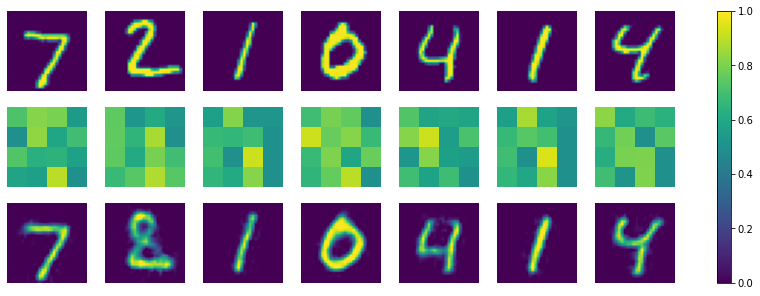

In [46]:
import matplotlib.pyplot as plt
import tensorflow as tf

n = 7
plt.figure(figsize=(15, 5))
axs = []
for i in range(n):
    
    # predict
    x = x_test[i]
    z = encoder(x.reshape(1,28,28,1))
    y = model(x.reshape(1,28,28,1))
    
    axs.append(plt.subplot(3, n, i+1))
    plt.axis('off')
    plt.imshow(x.reshape(28,28), vmin=0, vmax=1)
    
    axs.append(plt.subplot(3, n, n+i+1))
    plt.axis('off')
    plt.imshow(tf.reshape(z, (4,4)), vmin=0, vmax=1)
    
    axs.append(plt.subplot(3, n, 2*n+i+1))
    plt.axis('off')
    plt.imshow(tf.reshape(y, (28,28)), vmin=0, vmax=1)
plt.colorbar(ax=axs)

2. 4-split (shared)

In [9]:
import keras
import math
import numpy as np

class dataGen(keras.utils.Sequence):
    def __init__(self, xs, batch_size=32):
        self.batch_size=batch_size
        self.xs = xs
        self.on_epoch_end()
    def __len__(self):
        return math.ceil(len(self.xs)/self.batch_size)
    def split(self, im, nrows=14, ncols=14):
        r, h = im.shape[:-1] # exclude channel dim
        return (im.reshape(h//nrows,nrows,-1,ncols).swapaxes(1,2).reshape(-1,nrows,ncols,1))
    def __getitem__(self, i):
        batch = self.xs[i*self.batch_size:(i+1)*self.batch_size]
        x1s, x2s, x3s, x4s = [], [], [], []
        for x in batch:
            x1, x2, x3, x4 = self.split(x)
            x1s.append(x1)
            x2s.append(x2)
            x3s.append(x3)
            x4s.append(x4)
        xs = [np.array(x1s), np.array(x2s), np.array(x3s), np.array(x4s)]
        return xs, batch
    def on_epoch_end(self):
        self.xs = np.random.permutation(self.xs)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32') / 255.
train_data = dataGen(x_train)

x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_test = x_test.astype('float32') / 255.
test_data = dataGen(x_test)

In [32]:
model = keras.models.load_model('../models/48_4split_shared.h5')
encoder = keras.models.Model(model.inputs, model.get_layer('latent_concat').output)

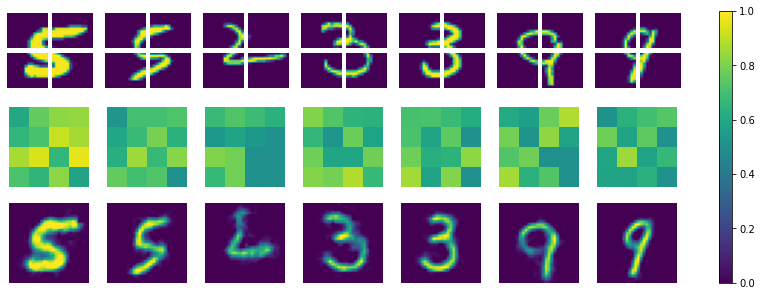

In [42]:
import matplotlib.pyplot as plt
import tensorflow as tf

n = 7
# n = 1
plt.figure(figsize=(15, 5))
axs = []
for (xs, ys), i in zip(test_data, range(n)):
#     axs.append(plt.subplot(3, n, i+1))
    ax = plt.subplot(3, n, i+1)
    for j in range(4):
        r = int(j/2)
        c = j%2
        ins = ax.inset_axes([c*0.55,0.5-r*0.5,0.5,0.5])
        ins.axis('off')
        ins.imshow(xs[j][0], vmin=0, vmax=1)
    ax.axis('off')
    axs.append(ax)
        
    z = encoder(xs)[0]
    
    axs.append(plt.subplot(3, n, n+i+1))
    plt.axis('off')
    plt.imshow(tf.reshape(z, (4,4)), vmin=0, vmax=1)
    
    y = model.predict(xs)
    axs.append(plt.subplot(3, n, 2*n+i+1))
    plt.axis('off')
    plt.imshow(tf.reshape(y[0], (28,28)), vmin=0, vmax=1)
plt.colorbar(ax=axs)